# Demo Part

In [8]:
"""
Comprehensive SST-2 Experiments:
- Baseline: Frozen DistilBERT + classification head (3 epochs)
- LoRA rank=8: epochs = 1, 2, 3 (epoch ablation)
- LoRA rank=16: epoch = 3 (rank ablation)
Metrics: Accuracy + F1
Results are saved to all_results.json
"""

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np
import evaluate
import json
from datetime import datetime
import torch


# ============================================================
# 0. basic setup
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_name = "distilbert-base-uncased"


# ============================================================
# 1. load dataset and preprocess
# ============================================================

print("Loading SST-2 dataset...")
dataset = load_dataset("glue", "sst2")

print(f"Train size: {len(dataset['train'])}")
print(f"Validation size: {len(dataset['validation'])}")
print(f"Test size: {len(dataset['test'])}")

tokenizer = AutoTokenizer.from_pretrained(model_name)


def preprocess_function(examples):
    return tokenizer(
        examples["sentence"],
        truncation=True,
        padding="max_length",
        max_length=128,
    )


print("Tokenizing datasets...")
tokenized_dataset = dataset.map(preprocess_function, batched=True)
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format(
    "torch", columns=["input_ids", "attention_mask", "labels"]
)
print("Data preprocessing complete.")


# ============================================================
# 2. metrics: accuracy + F1
# ============================================================

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(
        predictions=preds,
        references=labels,
        average="weighted",
    )

    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"],
    }


# ============================================================
# 3. Baseline experiment: frozen DistilBERT
# ============================================================

def run_baseline(num_epochs: int):
    print("\n" + "=" * 70)
    print(f"Running Baseline (frozen DistilBERT), epochs = {num_epochs}")
    print("=" * 70)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
    )

    # freeze backbone
    for param in model.distilbert.parameters():
        param.requires_grad = False

    # only classifier is trainable
    for param in model.classifier.parameters():
        param.requires_grad = True

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    trainable_pct = 100.0 * trainable_params / total_params

    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_pct:.4f}%)")

    training_args = TrainingArguments(
        output_dir=f"./results_baseline_e{num_epochs}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_steps=100,
        report_to="none",
        seed=42,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    print("\nBaseline evaluation results:")
    print(eval_results)

    result = {
        "experiment": "baseline",
        "model": model_name,
        "method": "frozen_backbone_classifier",
        "rank": None,
        "num_epochs": num_epochs,
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_percentage": trainable_pct,
        "accuracy": eval_results["eval_accuracy"],
        "f1": eval_results["eval_f1"],
        "loss": eval_results["eval_loss"],
    }

    return result


# ============================================================
# 4. LoRA experiment
# ============================================================

def run_lora(rank: int, num_epochs: int):
    print("\n" + "=" * 70)
    print(f"Running LoRA: rank = {rank}, epochs = {num_epochs}")
    print("=" * 70)

    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
    )

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=rank,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["q_lin", "v_lin"],
    )

    model = get_peft_model(base_model, lora_config)
    model.to(device)

    print("Trainable parameters with LoRA:")
    model.print_trainable_parameters()

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    trainable_pct = 100.0 * trainable_params / total_params

    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_pct:.4f}%)")

    training_args = TrainingArguments(
        output_dir=f"./results_lora_r{rank}_e{num_epochs}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_steps=100,
        report_to="none",
        seed=42,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    print("\nLoRA evaluation results:")
    print(eval_results)

    result = {
        "experiment": "lora",
        "model": model_name,
        "method": "lora",
        "rank": rank,
        "num_epochs": num_epochs,
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_percentage": trainable_pct,
        "accuracy": eval_results["eval_accuracy"],
        "f1": eval_results["eval_f1"],
        "loss": eval_results["eval_loss"],
    }

    return result


# ============================================================
# 5. run all experiments and save results
# ============================================================

if __name__ == "__main__":
    all_results = []

    # Baseline: 3 epochs
    baseline_result = run_baseline(num_epochs=3)
    all_results.append(baseline_result)

    # LoRA rank=8, epoch ablation: 1, 2, 3 epochs
    for e in [1, 2, 3]:
        res = run_lora(rank=8, num_epochs=e)
        all_results.append(res)

    # LoRA rank=16, 3 epochs (rank ablation)
    res_r16 = run_lora(rank=16, num_epochs=3)
    all_results.append(res_r16)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_file = f"all_results_{timestamp}.json"

    with open(out_file, "w") as f:
        json.dump(all_results, f, indent=2)

    print(f"\nAll experiment results saved to {out_file}")

Using device: cuda
Loading SST-2 dataset...


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Train size: 67349
Validation size: 872
Test size: 1821
Tokenizing datasets...


Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Data preprocessing complete.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Running Baseline (frozen DistilBERT), epochs = 3
Total parameters:     66,955,010
Trainable parameters: 592,130 (0.8844%)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.371900,0.372315,0.822248,0.821501
2,0.342700,0.362451,0.829128,0.828979
3,0.340700,0.367396,0.836009,0.836012



Baseline evaluation results:
{'eval_loss': 0.36739587783813477, 'eval_accuracy': 0.8360091743119266, 'eval_f1': 0.836012410295958, 'eval_runtime': 2.8291, 'eval_samples_per_second': 308.23, 'eval_steps_per_second': 9.897, 'epoch': 3.0}

Running LoRA: rank = 8, epochs = 1


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters with LoRA:
trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
Total parameters:     67,694,596
Trainable parameters: 739,586 (1.0925%)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.267900,0.284092,0.883028,0.883007


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



LoRA evaluation results:
{'eval_loss': 0.2840922772884369, 'eval_accuracy': 0.8830275229357798, 'eval_f1': 0.8830072039899022, 'eval_runtime': 2.9316, 'eval_samples_per_second': 297.444, 'eval_steps_per_second': 9.551, 'epoch': 1.0}

Running LoRA: rank = 8, epochs = 2
Trainable parameters with LoRA:
trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
Total parameters:     67,694,596
Trainable parameters: 739,586 (1.0925%)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.269100,0.277660,0.887615,0.887565
2,0.234500,0.283698,0.891055,0.890988


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



LoRA evaluation results:
{'eval_loss': 0.28369754552841187, 'eval_accuracy': 0.8910550458715596, 'eval_f1': 0.8909883381162379, 'eval_runtime': 2.928, 'eval_samples_per_second': 297.818, 'eval_steps_per_second': 9.563, 'epoch': 2.0}

Running LoRA: rank = 8, epochs = 3
Trainable parameters with LoRA:
trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
Total parameters:     67,694,596
Trainable parameters: 739,586 (1.0925%)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.269000,0.273609,0.881881,0.881887
2,0.231900,0.288771,0.888761,0.888648
3,0.220900,0.292885,0.891055,0.890975


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



LoRA evaluation results:
{'eval_loss': 0.29288536310195923, 'eval_accuracy': 0.8910550458715596, 'eval_f1': 0.8909745526255011, 'eval_runtime': 2.9412, 'eval_samples_per_second': 296.473, 'eval_steps_per_second': 9.52, 'epoch': 3.0}

Running LoRA: rank = 16, epochs = 3
Trainable parameters with LoRA:
trainable params: 887,042 || all params: 67,842,052 || trainable%: 1.3075
Total parameters:     67,842,052
Trainable parameters: 887,042 (1.3075%)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.269000,0.274366,0.891055,0.891061
2,0.228300,0.290883,0.894495,0.894379
3,0.221200,0.289935,0.892202,0.892115



LoRA evaluation results:
{'eval_loss': 0.29088273644447327, 'eval_accuracy': 0.8944954128440367, 'eval_f1': 0.8943791957058408, 'eval_runtime': 2.9399, 'eval_samples_per_second': 296.604, 'eval_steps_per_second': 9.524, 'epoch': 3.0}

All experiment results saved to all_results_20251212_165431.json


Loaded experiment data.


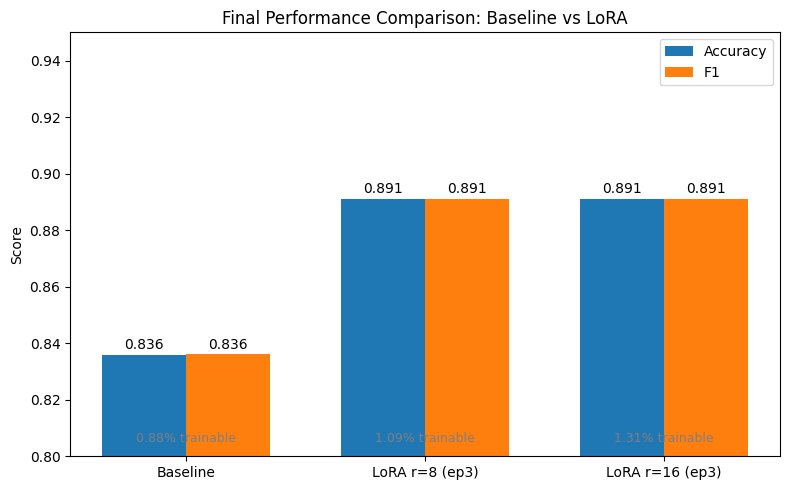

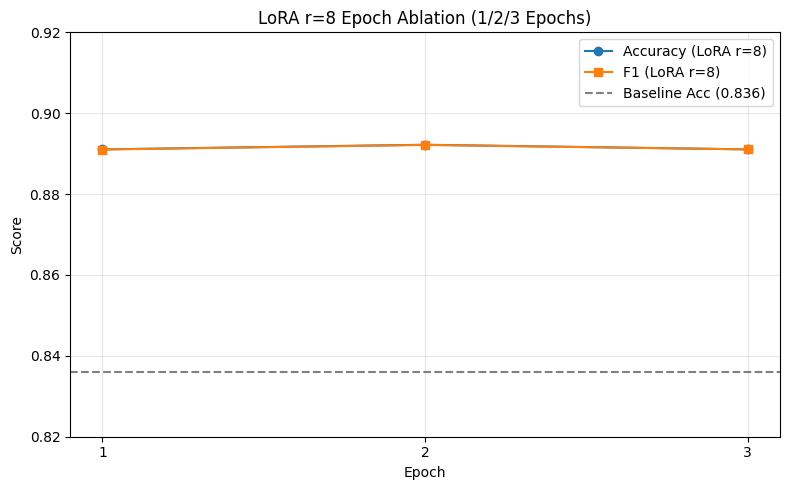

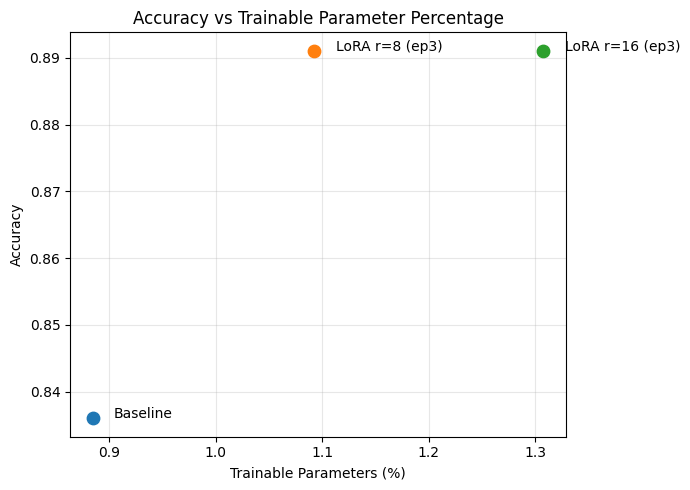

All plots generated.


In [9]:
import matplotlib.pyplot as plt

# ============================================================
# 1. Data from your JSON (hard-coded)
# ============================================================

experiments = [
    {
        "label": "Baseline",
        "experiment": "baseline",
        "rank": None,
        "num_epochs": 3,
        "trainable_pct": 0.8843699672362083,
        "accuracy": 0.8360091743119266,
        "f1": 0.836022762298825,
        "loss": 0.3649623692035675,
    },
    {
        "label": "LoRA r=8 (ep1)",
        "experiment": "lora",
        "rank": 8,
        "num_epochs": 1,
        "trainable_pct": 1.0925332946813067,
        "accuracy": 0.8910550458715596,
        "f1": 0.8910227822002127,
        "loss": 0.27995723485946655,
    },
    {
        "label": "LoRA r=8 (ep2)",
        "experiment": "lora",
        "rank": 8,
        "num_epochs": 2,
        "trainable_pct": 1.0925332946813067,
        "accuracy": 0.8922018348623854,
        "f1": 0.892154151629781,
        "loss": 0.28347542881965637,
    },
    {
        "label": "LoRA r=8 (ep3)",
        "experiment": "lora",
        "rank": 8,
        "num_epochs": 3,
        "trainable_pct": 1.0925332946813067,
        "accuracy": 0.8910550458715596,
        "f1": 0.8910571956511609,
        "loss": 0.27263057231903076,
    },
    {
        "label": "LoRA r=16 (ep3)",
        "experiment": "lora",
        "rank": 16,
        "num_epochs": 3,
        "trainable_pct": 1.307510568813573,
        "accuracy": 0.8910550458715596,
        "f1": 0.8910399931370999,
        "loss": 0.27473872900009155,
    },
]

print("Loaded experiment data.")


# ============================================================
# 2. Figure 1 - Final Comparison (Baseline vs LoRA)
# ============================================================

final_methods = ["Baseline", "LoRA r=8 (ep3)", "LoRA r=16 (ep3)"]

labels = []
accs = []
f1s = []
tps = []

for exp in experiments:
    if exp["label"] in final_methods:
        labels.append(exp["label"])
        accs.append(exp["accuracy"])
        f1s.append(exp["f1"])
        tps.append(exp["trainable_pct"])

plt.figure(figsize=(8, 5))

x = range(len(labels))
w = 0.35

plt.bar([i - w/2 for i in x], accs, width=w, label="Accuracy")
plt.bar([i + w/2 for i in x], f1s, width=w, label="F1")

plt.xticks(x, labels)
plt.ylim(0.80, 0.95)
plt.ylabel("Score")
plt.title("Final Performance Comparison: Baseline vs LoRA")

# annotate
for i in range(len(labels)):
    plt.text(i - w/2, accs[i] + 0.002, f"{accs[i]:.3f}", ha="center")
    plt.text(i + w/2, f1s[i] + 0.002, f"{f1s[i]:.3f}", ha="center")
    plt.text(i, 0.805, f"{tps[i]:.2f}% trainable", ha="center", fontsize=9, color="gray")

plt.legend()
plt.tight_layout()
plt.savefig("final_comparison.png", dpi=200)
plt.show()


# ============================================================
# 3. Figure 2 - LoRA r=8 Epoch Ablation
# ============================================================

lora8 = [e for e in experiments if e["rank"] == 8]
lora8 = sorted(lora8, key=lambda d: d["num_epochs"])

epochs = [e["num_epochs"] for e in lora8]
accs_e = [e["accuracy"] for e in lora8]
f1s_e = [e["f1"] for e in lora8]

baseline_acc = experiments[0]["accuracy"]
baseline_f1  = experiments[0]["f1"]

plt.figure(figsize=(8, 5))

plt.plot(epochs, accs_e, marker="o", label="Accuracy (LoRA r=8)")
plt.plot(epochs, f1s_e, marker="s", label="F1 (LoRA r=8)")

plt.axhline(baseline_acc, color="gray", linestyle="--", label=f"Baseline Acc ({baseline_acc:.3f})")

plt.xticks(epochs)
plt.ylim(0.82, 0.92)
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("LoRA r=8 Epoch Ablation (1/2/3 Epochs)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("lora_r8_epoch_ablation.png", dpi=200)
plt.show()


# ============================================================
# 4. Figure 3 - Parameter Efficiency vs Performance
# ============================================================

plt.figure(figsize=(7, 5))

for e in final_methods:
    exp = next(item for item in experiments if item["label"] == e)
    plt.scatter(exp["trainable_pct"], exp["accuracy"], s=80)
    plt.text(exp["trainable_pct"] + 0.02, exp["accuracy"], exp["label"])

plt.xlabel("Trainable Parameters (%)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Trainable Parameter Percentage")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("accuracy_vs_params.png", dpi=200)
plt.show()

print("All plots generated.")

# Testing on additional dataset

In [10]:
"""
IMDb-only PEFT Experiments (Baseline + LoRA Ablations)

Dataset:
- IMDb via Hugging Face: load_dataset("imdb")
- IMDb has no validation split by default; we create one from train.

Experiments:
- Baseline: Frozen DistilBERT + classifier head (3 epochs)
- LoRA rank=8: epochs = 1, 2, 3  (epoch ablation)
- LoRA rank=16: epochs = 3       (rank ablation)

Metrics (validation):
- accuracy
- precision/recall/F1 (macro)
- precision/recall/F1 (weighted)
- per-class precision/recall/F1 for label=1 (positive) and label=0 (negative)

Output:
- all_results_imdb_<timestamp>.json
"""

from __future__ import annotations

import argparse
import inspect
import json
from datetime import datetime

import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, TaskType


# ============================================================
# 0. Robust argparse for Colab/Jupyter
# ============================================================

def parse_args(argv=None) -> argparse.Namespace:
    p = argparse.ArgumentParser(add_help=True)
    p.add_argument("--imdb-val-frac", type=float, default=0.1)
    p.add_argument("--max-length", type=int, default=512)
    p.add_argument("--seed", type=int, default=42)
    args, _unknown = p.parse_known_args(argv)
    return args


# ============================================================
# 1. Metrics computed from confusion counts (binary)
# ============================================================

def safe_div(a: float, b: float) -> float:
    return a / b if b != 0 else 0.0


def compute_binary_metrics(preds: np.ndarray, labels: np.ndarray) -> dict:
    """
    Binary labels are {0,1}.
    Confusion terms:
      TP = pred=1,label=1
      FP = pred=1,label=0
      FN = pred=0,label=1
      TN = pred=0,label=0
    """
    preds = preds.astype(int)
    labels = labels.astype(int)

    tp = int(np.sum((preds == 1) & (labels == 1)))
    fp = int(np.sum((preds == 1) & (labels == 0)))
    fn = int(np.sum((preds == 0) & (labels == 1)))
    tn = int(np.sum((preds == 0) & (labels == 0)))
    n = int(len(labels))

    accuracy = safe_div(tp + tn, n)

    # Class 1 ("positive")
    prec_pos = safe_div(tp, tp + fp)
    rec_pos = safe_div(tp, tp + fn)
    f1_pos = safe_div(2 * prec_pos * rec_pos, prec_pos + rec_pos)

    # Class 0 ("negative") treated as "positive class" for metrics
    prec_neg = safe_div(tn, tn + fn)
    rec_neg = safe_div(tn, tn + fp)
    f1_neg = safe_div(2 * prec_neg * rec_neg, prec_neg + rec_neg)

    support_pos = tp + fn
    support_neg = tn + fp

    precision_macro = (prec_pos + prec_neg) / 2.0
    recall_macro = (rec_pos + rec_neg) / 2.0
    f1_macro = (f1_pos + f1_neg) / 2.0

    precision_weighted = safe_div(prec_pos * support_pos + prec_neg * support_neg, n)
    recall_weighted = safe_div(rec_pos * support_pos + rec_neg * support_neg, n)
    f1_weighted = safe_div(f1_pos * support_pos + f1_neg * support_neg, n)

    return {
        "accuracy": accuracy,
        "precision_macro": precision_macro,
        "recall_macro": recall_macro,
        "f1_macro": f1_macro,
        "precision_weighted": precision_weighted,
        "recall_weighted": recall_weighted,
        "f1_weighted": f1_weighted,
        "precision_pos": prec_pos,
        "recall_pos": rec_pos,
        "f1_pos": f1_pos,
        "precision_neg": prec_neg,
        "recall_neg": rec_neg,
        "f1_neg": f1_neg,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
    }


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return compute_binary_metrics(preds=preds, labels=labels)


# ============================================================
# 2. TrainingArguments compatibility helper (eval_strategy vs evaluation_strategy)
# ============================================================

def make_training_arguments(**kwargs) -> TrainingArguments:
    """
    Transformers versions differ:
    - some use eval_strategy
    - others use evaluation_strategy
    Detect and set the correct key.
    """
    sig = inspect.signature(TrainingArguments.__init__)
    params = sig.parameters

    if "eval_strategy" in params and "evaluation_strategy" not in params:
        kwargs["eval_strategy"] = kwargs.pop("evaluation_strategy")
    elif "evaluation_strategy" in params:
        pass
    else:
        kwargs["eval_strategy"] = kwargs.pop("evaluation_strategy")

    return TrainingArguments(**kwargs)


# ============================================================
# 3. Experiment runners
# ============================================================

def count_params(model) -> tuple[int, int, float]:
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    trainable_pct = 100.0 * trainable_params / total_params
    return trainable_params, total_params, trainable_pct


def run_baseline(model_name: str, tokenized_dataset, num_epochs: int, seed: int) -> dict:
    print("\n" + "=" * 70)
    print(f"Running Baseline (frozen encoder), epochs = {num_epochs}")
    print("=" * 70)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Freeze DistilBERT encoder
    for p in model.distilbert.parameters():
        p.requires_grad = False

    # Train only classifier head
    for p in model.classifier.parameters():
        p.requires_grad = True

    trainable_params, total_params, trainable_pct = count_params(model)
    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_pct:.4f}%)")

    args = make_training_arguments(
        output_dir=f"./results_baseline_e{num_epochs}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_steps=100,
        report_to="none",
        seed=seed,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )

    train_out = trainer.train()
    eval_out = trainer.evaluate()

    result = {
        "experiment": "baseline",
        "model": model_name,
        "method": "frozen_backbone_classifier",
        "rank": None,
        "num_epochs": num_epochs,
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_percentage": trainable_pct,
        "train_runtime": train_out.metrics.get("train_runtime"),
        "train_samples_per_second": train_out.metrics.get("train_samples_per_second"),
    }
    for k, v in eval_out.items():
        if k.startswith("eval_"):
            result[k] = v
    return result


def run_lora(model_name: str, tokenized_dataset, rank: int, num_epochs: int, seed: int) -> dict:
    print("\n" + "=" * 70)
    print(f"Running LoRA: rank = {rank}, epochs = {num_epochs}")
    print("=" * 70)

    base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=rank,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["q_lin", "v_lin"],
    )

    model = get_peft_model(base_model, lora_config)

    if torch.cuda.is_available():
        model.to("cuda")

    trainable_params, total_params, trainable_pct = count_params(model)
    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,} ({trainable_pct:.4f}%)")

    args = make_training_arguments(
        output_dir=f"./results_lora_r{rank}_e{num_epochs}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_steps=100,
        report_to="none",
        seed=seed,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        compute_metrics=compute_metrics,
    )

    train_out = trainer.train()
    eval_out = trainer.evaluate()

    result = {
        "experiment": "lora",
        "model": model_name,
        "method": "lora",
        "rank": rank,
        "num_epochs": num_epochs,
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_percentage": trainable_pct,
        "train_runtime": train_out.metrics.get("train_runtime"),
        "train_samples_per_second": train_out.metrics.get("train_samples_per_second"),
    }
    for k, v in eval_out.items():
        if k.startswith("eval_"):
            result[k] = v
    return result


# ============================================================
# 4. Main: IMDb only
# ============================================================

def main():
    cfg = parse_args()

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    print("Dataset: imdb")

    # Load IMDb
    ds = load_dataset("imdb")

    # Create validation split from train
    split = ds["train"].train_test_split(test_size=cfg.imdb_val_frac, seed=cfg.seed)
    ds["train"] = split["train"]
    ds["validation"] = split["test"]
    # Keep ds["test"] as provided

    print(f"Train size: {len(ds['train'])}")
    print(f"Validation size: {len(ds['validation'])}")
    print(f"Test size: {len(ds['test'])}")

    model_name = "distilbert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_function(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            padding="max_length",
            max_length=cfg.max_length,
        )

    print("Tokenizing datasets...")
    tokenized_ds = ds.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.rename_column("label", "labels")
    tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    print("Tokenization complete.")

    all_results = []

    # Baseline: 3 epochs
    all_results.append(run_baseline(model_name, tokenized_ds, num_epochs=3, seed=cfg.seed))

    # LoRA rank=8: epoch ablation 1,2,3
    for e in [1, 2, 3]:
        all_results.append(run_lora(model_name, tokenized_ds, rank=8, num_epochs=e, seed=cfg.seed))

    # LoRA rank=16: 3 epochs
    all_results.append(run_lora(model_name, tokenized_ds, rank=16, num_epochs=3, seed=cfg.seed))

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_file = f"all_results_imdb_{timestamp}.json"
    with open(out_file, "w") as f:
        json.dump(all_results, f, indent=2)

    print(f"Saved results to: {out_file}")


if __name__ == "__main__":
    main()

Using device: cuda
Dataset: imdb


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 22500
Validation size: 2500
Test size: 25000
Tokenizing datasets...


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenization complete.

Running Baseline (frozen encoder), epochs = 3
Total parameters:     66,955,010
Trainable parameters: 592,130 (0.8844%)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Pos,Recall Pos,F1 Pos,Precision Neg,Recall Neg,F1 Neg,Tp,Fp,Fn,Tn
1,0.374700,0.341886,0.850800,0.859717,0.851241,0.849978,0.860042,0.850800,0.849916,0.917769,0.772474,0.838877,0.801664,0.930008,0.861080,971,87,286,1156
2,0.351100,0.319071,0.866400,0.868467,0.866611,0.866256,0.868630,0.866400,0.866232,0.897502,0.828958,0.861869,0.839432,0.904264,0.870643,1042,119,215,1124
3,0.355900,0.310436,0.875600,0.875651,0.875567,0.875585,0.875633,0.875600,0.875593,0.872441,0.881464,0.876929,0.878862,0.869670,0.874242,1108,162,149,1081


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Running LoRA: rank = 8, epochs = 1
Total parameters:     67,694,596
Trainable parameters: 739,586 (1.0925%)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Pos,Recall Pos,F1 Pos,Precision Neg,Recall Neg,F1 Neg,Tp,Fp,Fn,Tn
1,0.265500,0.245982,0.902000,0.902003,0.901990,0.901995,0.902001,0.902000,0.901999,0.901587,0.903739,0.902662,0.902419,0.900241,0.901329,1136,124,121,1119


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Running LoRA: rank = 8, epochs = 2
Total parameters:     67,694,596
Trainable parameters: 739,586 (1.0925%)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Pos,Recall Pos,F1 Pos,Precision Neg,Recall Neg,F1 Neg,Tp,Fp,Fn,Tn
1,0.257000,0.285186,0.891600,0.898659,0.891975,0.891182,0.898964,0.891600,0.891144,0.953125,0.824980,0.884435,0.844193,0.958970,0.897928,1037,51,220,1192
2,0.237600,0.230346,0.911200,0.911196,0.911206,0.911199,0.911206,0.911200,0.911201,0.913009,0.910103,0.911554,0.909383,0.912309,0.910843,1144,109,113,1134


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Running LoRA: rank = 8, epochs = 3
Total parameters:     67,694,596
Trainable parameters: 739,586 (1.0925%)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Pos,Recall Pos,F1 Pos,Precision Neg,Recall Neg,F1 Neg,Tp,Fp,Fn,Tn
1,0.257400,0.304495,0.881200,0.891466,0.881655,0.880502,0.891829,0.881200,0.880451,0.956274,0.800318,0.871373,0.826657,0.962993,0.889632,1006,46,251,1197
2,0.236100,0.249823,0.906800,0.909430,0.907028,0.906682,0.909622,0.906800,0.906663,0.943674,0.866348,0.903360,0.875186,0.947707,0.910004,1089,65,168,1178
3,0.247700,0.228746,0.912000,0.912001,0.911993,0.911996,0.912000,0.912000,0.912000,0.911835,0.913286,0.912560,0.912168,0.910700,0.911433,1148,111,109,1132


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Running LoRA: rank = 16, epochs = 3
Total parameters:     67,842,052
Trainable parameters: 887,042 (1.3075%)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Precision Weighted,Recall Weighted,F1 Weighted,Precision Pos,Recall Pos,F1 Pos,Precision Neg,Recall Neg,F1 Neg,Tp,Fp,Fn,Tn
1,0.258900,0.302246,0.880400,0.891278,0.880869,0.879653,0.891652,0.880400,0.879600,0.957935,0.797136,0.870169,0.824622,0.964602,0.889136,1002,44,255,1199
2,0.233400,0.248451,0.908400,0.911039,0.908628,0.908284,0.911232,0.908400,0.908265,0.945407,0.867940,0.905019,0.876672,0.949316,0.911549,1091,63,166,1180
3,0.244200,0.226588,0.913600,0.913595,0.913602,0.913598,0.913602,0.913600,0.913600,0.914741,0.913286,0.914013,0.912450,0.913918,0.913183,1148,107,109,1136


Saved results to: all_results_imdb_20251212_192354.json


DEMO FOR USER

In [14]:
"""
Demo Setup: Load Best LoRA Model
Using checkpoint-12630 (final checkpoint)
"""

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel
import os

print("="*70)
print("Loading Model for Demo")
print("="*70)

# Use the final checkpoint (highest number = most trained)
model_path = "./results_lora_r8_e3/checkpoint-12630"

print(f"\nLoading model from: {model_path}")

# Load tokenizer and base model
print("Loading tokenizer and base model...")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
base_model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# Load LoRA adapter
print("Loading LoRA adapter...")
model = PeftModel.from_pretrained(base_model, model_path)
model.eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"\nModel loaded successfully on {device}")
print("Ready for demo")
print("="*70)


# Define prediction function
def predict_sentiment(text, show_details=True):
    """
    Predict sentiment for input text

    Args:
        text: Input sentence
        show_details: Show probability distribution

    Returns:
        Dictionary with prediction results
    """

    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0]
        pred_label = torch.argmax(outputs.logits, dim=1).item()

    sentiment = "Positive" if pred_label == 1 else "Negative"
    confidence = probs[pred_label].item() * 100

    # Display results
    print("\n" + "="*70)
    print(f"Input: \"{text}\"")
    print("-"*70)
    print(f"Prediction: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")

    if show_details:
        print(f"\nProbability Distribution:")
        print(f"   Negative: {probs[0].item():.4f} ({probs[0].item()*100:.2f}%)")
        print(f"   Positive: {probs[1].item():.4f} ({probs[1].item()*100:.2f}%)")

        # Visual bars
        neg_bar = int(probs[0].item() * 50)
        pos_bar = int(probs[1].item() * 50)
        print(f"\n   Negative: [{'=' * neg_bar}]")
        print(f"   Positive: [{'=' * pos_bar}]")

    print("="*70)

    return {
        "text": text,
        "sentiment": sentiment,
        "confidence": confidence,
        "prob_negative": probs[0].item(),
        "prob_positive": probs[1].item()
    }


# Test the function
print("\nTesting prediction function:")
test_result = predict_sentiment("This movie is great!")

Loading Model for Demo

Loading model from: ./results_lora_r8_e3/checkpoint-12630
Loading tokenizer and base model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading LoRA adapter...

Model loaded successfully on cuda
Ready for demo

Testing prediction function:

Input: "This movie is great!"
----------------------------------------------------------------------
Prediction: Positive
Confidence: 99.96%

Probability Distribution:
   Negative: 0.0004 (0.04%)
   Positive: 0.9996 (99.96%)

   Negative: []
   Positive: [=================================================]


In [15]:
"""
Demo Examples: Preset Test Cases
"""

print("\n" + "="*70)
print("SENTIMENT ANALYSIS DEMO - PRESET EXAMPLES")
print("="*70 + "\n")

demo_examples = [
    {
        "text": "This movie is absolutely fantastic!",
        "expected": "Positive",
        "difficulty": "Easy"
    },
    {
        "text": "Worst film I've ever seen.",
        "expected": "Negative",
        "difficulty": "Easy"
    },
    {
        "text": "It's not bad, but could be better.",
        "expected": "Negative",
        "difficulty": "Medium"
    },
    {
        "text": "Great acting but weak plot.",
        "expected": "Negative",
        "difficulty": "Medium"
    },
    {
        "text": "Not the worst movie ever made.",
        "expected": "Neutral/Negative",
        "difficulty": "Hard"
    }
]

results_demo = []

for i, example in enumerate(demo_examples, 1):
    print(f"\n{'='*70}")
    print(f"Example {i}/{len(demo_examples)} - Difficulty: {example['difficulty']}")
    print(f"Expected: {example['expected']}")
    print("="*70)

    result = predict_sentiment(example["text"], show_details=True)
    results_demo.append(result)

print("\n" + "="*70)
print("All demo examples completed")
print("="*70)


SENTIMENT ANALYSIS DEMO - PRESET EXAMPLES


Example 1/5 - Difficulty: Easy
Expected: Positive

Input: "This movie is absolutely fantastic!"
----------------------------------------------------------------------
Prediction: Positive
Confidence: 99.97%

Probability Distribution:
   Negative: 0.0003 (0.03%)
   Positive: 0.9997 (99.97%)

   Negative: []
   Positive: [=================================================]

Example 2/5 - Difficulty: Easy
Expected: Negative

Input: "Worst film I've ever seen."
----------------------------------------------------------------------
Prediction: Negative
Confidence: 99.79%

Probability Distribution:
   Negative: 0.9979 (99.79%)
   Positive: 0.0021 (0.21%)

   Negative: [=================================================]
   Positive: []

Example 3/5 - Difficulty: Medium
Expected: Negative

Input: "It's not bad, but could be better."
----------------------------------------------------------------------
Prediction: Positive
Confidence: 57.50%

Probabi

In [17]:
"""
Interactive Demo - Colab Forms
"""

# @title Sentiment Analysis Demo { run: "auto" }
# @markdown Enter any movie review or opinion:

user_input = "This movie is absolutely fantastic!"  # @param {type:"string"}
show_probabilities = True  # @param {type:"boolean"}

if user_input.strip():
    print("Analyzing your input...\n")
    result = predict_sentiment(user_input, show_details=show_probabilities)
else:
    print("Please enter text in the form above")

Analyzing your input...


Input: "This movie is absolutely fantastic!"
----------------------------------------------------------------------
Prediction: Positive
Confidence: 99.97%

Probability Distribution:
   Negative: 0.0003 (0.03%)
   Positive: 0.9997 (99.97%)

   Negative: []
   Positive: [=================================================]
